In [1]:
import os

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.transforms import v2
from torchvision.io import read_image

%matplotlib inline
from loguru import logger


/home/pyml/anaconda3/envs/objrecognition/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup hyperparameters

In [2]:
batch_size = 16
learning_rate = 0.0001
num_epochs = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


### Build dataset

In [3]:
label_map = {
    "cat": 0,
    "dog": 1,
    "horse": 2,
}

class MyImageDataset(Dataset):
    def __init__(self, csv_file, transform=None, tag="train"):
        self.transform = transform
        df = pd.read_csv(csv_file)
        df_selected = df[df["tag"] == tag]
        self.imgs = df_selected["filepath"].values
        self.labels = df_selected["label"].values

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = read_image(img_path)
        label = label_map[self.labels[idx]]
        if self.transform:
            img = self.transform(img)
        return img, label
    

# testing
dataset = MyImageDataset(
    "data.csv",
    transform=v2.Compose([v2.Resize((64, 64)), v2.ToTensor()])
)

img, label = next(iter(dataset))
logger.info(f"{img.shape}, {label}")

/home/pyml/anaconda3/envs/objrecognition/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(
2024-09-29 14:49:52.998 | INFO     | __main__:<module>:34 - torch.Size([3, 64, 64]), 2


2024-09-29 14:49:53.298 | INFO     | __main__:<module>:42 - torch.Size([16, 3, 128, 128]), torch.Size([16])


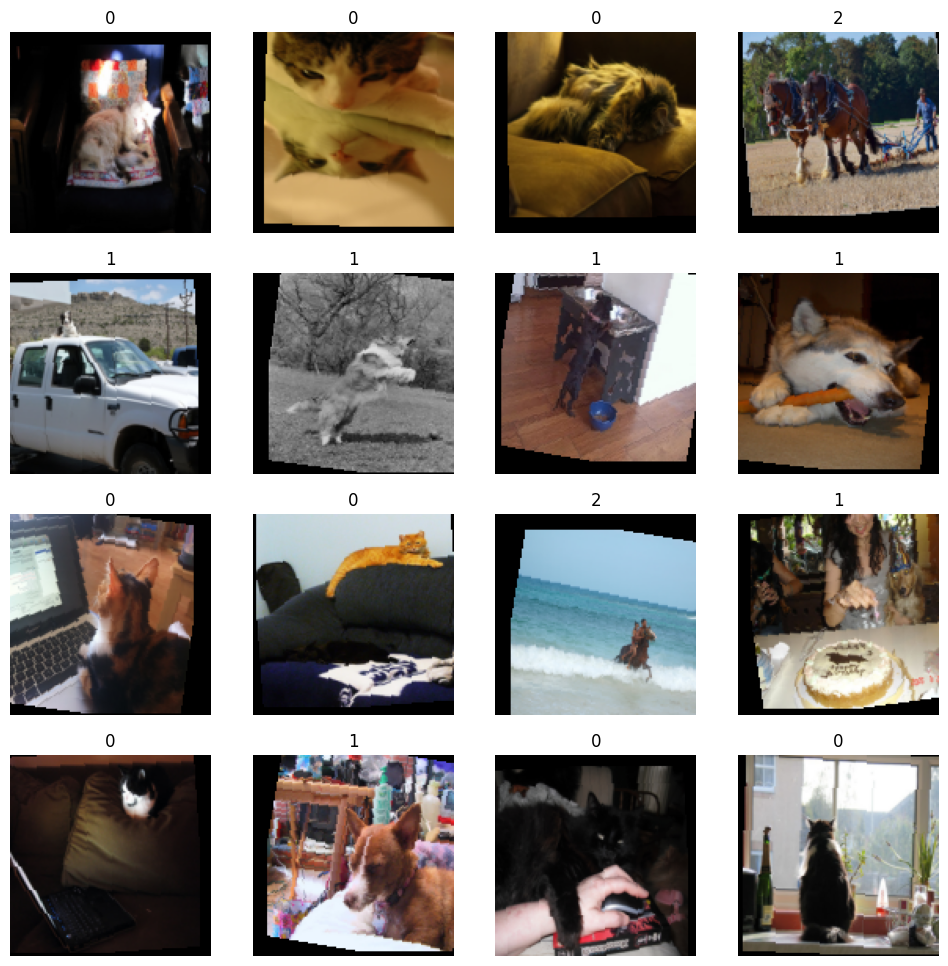

In [4]:
# build train and validation dataloaders

train_transform = v2.Compose([
    v2.Resize((128, 128)),
    v2.RandomHorizontalFlip(),
    v2.RandomRotation(10),
    v2.RandomAffine(0, translate=(0.1, 0.1)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tranform = v2.Compose([
    v2.Resize((128, 128)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = MyImageDataset(
    "data.csv",
    transform=train_transform,
    tag="train"
)

val_dataset = MyImageDataset(
    "data.csv",
    transform=test_tranform,
    tag="val"
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=4, pin_memory=True
)

# testing
imgs, labels = next(iter(train_loader))
logger.info(f"{imgs.shape}, {labels.shape}")
# visualize the images (4x4 grid)
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for i in range(16):
    img = imgs[i].permute(1, 2, 0)
    # reverse normalization
    img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
    axes.flat[i].imshow(img)
    axes.flat[i].set_title(labels[i].item())
    axes.flat[i].axis("off")

plt.show()

### Build Pre-trained ResNet model

In [5]:
model = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.DEFAULT
)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# replace the fc layer

class ImageClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = torchvision.models.resnet18(
            weights=torchvision.models.ResNet18_Weights.DEFAULT
        )

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, inputs):
        return self.model(inputs)

model = ImageClassifier(num_classes=len(label_map))
model

ImageClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

## Setup learning

In [7]:
# define opjective function
criterion = nn.CrossEntropyLoss()

# setup Adam optimizer
optimizer = Adam(
    params=model.parameters(),
    lr=learning_rate, betas=(0.9, 0.999),
)

# setup leanring-rate scheduler (linear decay)
epoch_start_decay = num_epochs // 2
n_epochs_decay = num_epochs - epoch_start_decay
def lambda_rule(epoch):
    decay = max(0, epoch + epoch_start_decay - num_epochs)
    lr_l = 1.0 - decay / float(n_epochs_decay + 1)
    return lr_l
    
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_rule)

## Train model

In [8]:
model.to(device)

save_freq = 10
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)
best_val_acc = 0.0

train_metrics, val_metrics = [], []
for epoch in range(num_epochs):
    train_loss, train_acc, total = 0.0, 0.0, 0
    # run training loop
    model.train()
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        
        logits = model(batch_x)

        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(logits, dim=1)
        total += len(batch_y)
        train_loss += loss.item() * len(batch_y)
        train_acc += (preds == batch_y).sum().item()

    # update learning rate
    scheduler.step()

    avg_train_loss = train_loss / total
    avg_train_acc = train_acc / total

    # run validaiton loop
    model.eval()
    val_loss, val_acc, total = 0.0, 0.0, 0
    with torch.no_grad():
        for batch_x_val, batch_y_val in val_loader:
            batch_x_val = batch_x_val.to(device)
            batch_y_val = batch_y_val.to(device)
            logits = model(batch_x_val)
            loss = criterion(logits, batch_y_val)
            total += len(batch_y_val)
            val_loss += loss.item() * len(batch_y_val)
            val_acc += (torch.argmax(logits, 1) == batch_y_val).sum().item()
    avg_val_loss = val_loss / total
    avg_val_acc = val_acc / total
    logger.info(
        f'Epoch {epoch}/{num_epochs}  '
        f'Train Loss: {avg_train_loss:.4f} Acc: {avg_train_acc:.4f}  '
        f'Val Loss: {avg_val_loss:.4f} Acc: {avg_val_acc:.4f}'
    )

    train_metrics.append((avg_train_loss, avg_train_acc))
    val_metrics.append((avg_val_loss, avg_val_acc))

    if epoch % save_freq == 0:
        torch.save(
            model.state_dict(), os.path.join(save_dir, f"model_{epoch}.pth")
        )

    # save the best model
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        torch.save(
            model.state_dict(), os.path.join(save_dir, "best_model.pth")
        )
        logger.info(
            f"Best model saved at epoch {epoch}, best val acc: {best_val_acc:.4f}"
        )


2024-09-29 14:50:02.776 | INFO     | __main__:<module>:50 - Epoch 0/100  Train Loss: 0.6886 Acc: 0.6891  Val Loss: 0.5348 Acc: 0.7480
2024-09-29 14:50:02.903 | INFO     | __main__:<module>:70 - Best model saved at epoch 0, best val acc: 0.7480
2024-09-29 14:50:11.618 | INFO     | __main__:<module>:50 - Epoch 1/100  Train Loss: 0.5475 Acc: 0.7606  Val Loss: 0.4984 Acc: 0.7809
2024-09-29 14:50:11.684 | INFO     | __main__:<module>:70 - Best model saved at epoch 1, best val acc: 0.7809
2024-09-29 14:50:20.172 | INFO     | __main__:<module>:50 - Epoch 2/100  Train Loss: 0.4761 Acc: 0.8005  Val Loss: 0.5527 Acc: 0.7717
2024-09-29 14:50:28.680 | INFO     | __main__:<module>:50 - Epoch 3/100  Train Loss: 0.4107 Acc: 0.8234  Val Loss: 0.5431 Acc: 0.7795
2024-09-29 14:50:37.277 | INFO     | __main__:<module>:50 - Epoch 4/100  Train Loss: 0.3791 Acc: 0.8361  Val Loss: 0.5709 Acc: 0.7781
2024-09-29 14:50:45.812 | INFO     | __main__:<module>:50 - Epoch 5/100  Train Loss: 0.3441 Acc: 0.8589  Val L

### Plot learning curves

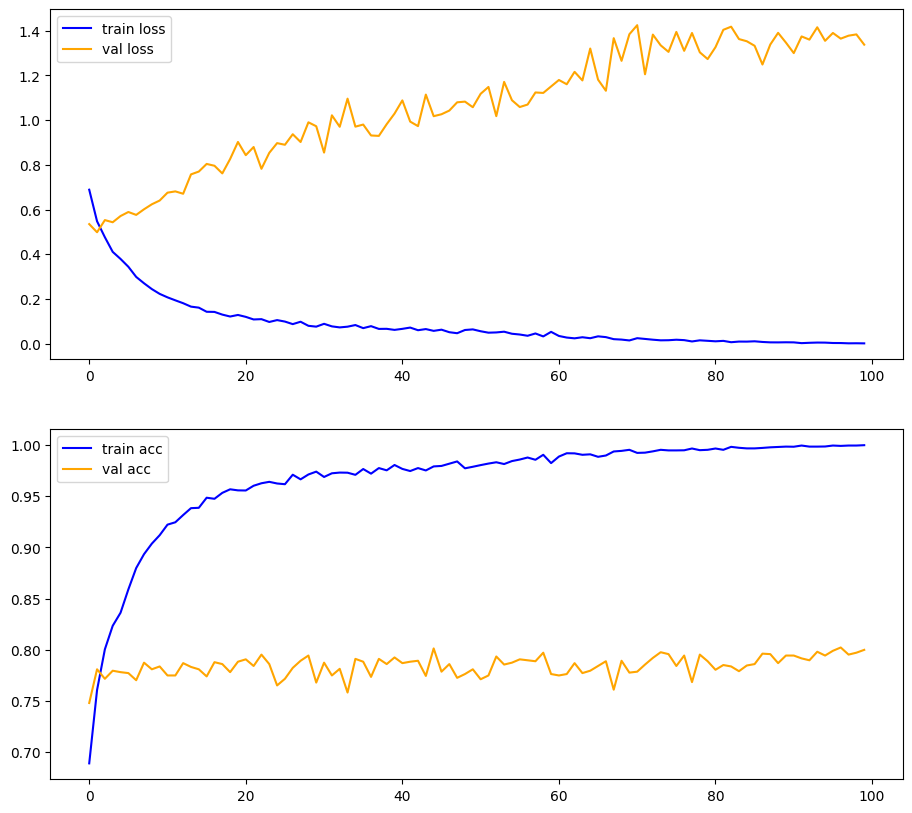

In [9]:
import seaborn as sns

fig, axes = plt.subplots(2, 1, figsize=(11, 10))

sns.lineplot(
    [v[0] for v in train_metrics], ax=axes[0],
    label='train loss', color='blue'
)
sns.lineplot(
    [v[0] for v in val_metrics], ax=axes[0],
    label='val loss', color='orange'
)

sns.lineplot(
    [v[1] for v in train_metrics], ax=axes[1],
    label='train acc', color='blue'
)
sns.lineplot(
    [v[1] for v in val_metrics], ax=axes[1],
    label='val acc', color='orange'
)
plt.show()

### Evaluation on test set

In [11]:
model = ImageClassifier(num_classes=len(label_map))

# load the best model
model.load_state_dict(torch.load('checkpoints/best_model.pth'))

model.to(device)
model.eval()

ImageClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [12]:
test_dataset = MyImageDataset(
    "data.csv",
    transform=test_tranform,
    tag="test"
)

test_loader = DataLoader(
    test_dataset, batch_size=1, shuffle=False,
)

In [13]:
predictions, targets = [], []
for image, label in tqdm(test_dataset):
    image = image.to(device).unsqueeze(0)
    with torch.no_grad():
        logits = model(image)

    pred_label = torch.argmax(logits, dim=1).item()
    predictions.append(pred_label)
    targets.append(label)

100%|██████████| 457/457 [00:01<00:00, 330.57it/s]


In [17]:
from sklearn.metrics import classification_report

report = classification_report(
    y_true=targets, y_pred=predictions,
    target_names=label_map.keys()
)

print(report)

              precision    recall  f1-score   support

         cat       0.84      0.84      0.84       172
         dog       0.69      0.74      0.71       161
       horse       0.84      0.77      0.80       124

    accuracy                           0.78       457
   macro avg       0.79      0.78      0.78       457
weighted avg       0.79      0.78      0.78       457



In [22]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(
    y_true=targets, y_pred=predictions,
    normalize='true'
)

print(conf_mat)

[[0.8372093  0.15697674 0.00581395]
 [0.1552795  0.73913043 0.10559006]
 [0.02419355 0.20967742 0.76612903]]


<Axes: >

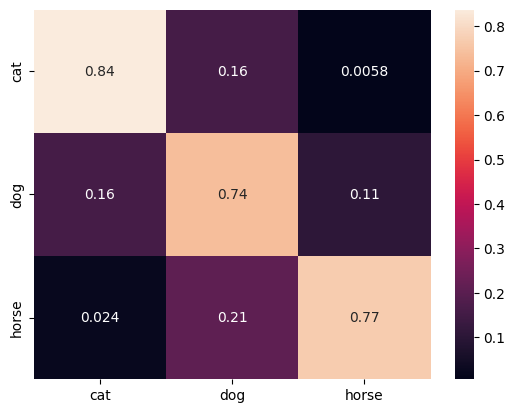

In [24]:
conf_mat = confusion_matrix(
    y_true=targets, y_pred=predictions, normalize='true'
)
sns.heatmap(
    conf_mat, annot=True,
    xticklabels=label_map.keys(),
    yticklabels=label_map.keys()
)